In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)

  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


true

In [2]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotation=angle;
                kargs...
            )

    return m

end

plotRods2D! (generic function with 2 methods)

In [6]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :v => Float64,  #Swimming speed
        :theta => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :active => Bool,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64, #CheYP levels, probability of tumblingç
        :G => Float64,
        :λ => Float64,
        :P => Float64,
        :M => Float64
    ),

    model = Dict(

        :Dr_run => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :ε2 => Float64,
        :ε3 => Float64,
        :K => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        :Yp0 => Float64,   #CheYP adapted
        :α => Float64,      #Gain in thesignaling pathway - from receptor to CheYP 
        :ωFrec => Float64      #Basal switching frequency
        # :mm => Float64
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote

        # mm = 0.2*exp((x - com.simBox[1,1])*3*30^(-3 ))
      
        F = ε0 + ε1 * methyl + Nrec * log((1 + mm / Ki) / (1 + mm / Ka)) #Equació del paper per definir activitat del receptor
        F0 = log(α / Yp0 - 1  )         #Energia lliure en estat adaptat

        dt(methyl) = -(F - F0) / (ε1 * τm)          #Methylation
        Yp = α / (1 + exp(F))    
        G = ε2 / 4 - (ε3 / 2) / (1 + (K / Yp))                   #CheYp segons activitat receptor
        if active 
            λ = ωFrec*exp(-G)*dt 
            P = 1 - exp(-λ * dt)
            M = mm
        else
            λ = ωFrec*exp(G)*dt 
            P = 1 - exp(-λ * dt)
            M = mm
        end

        dt(x) = active * vx  #Change position acording to constant speed afected by forces
        dt(y) = active * vy  
    end,

    agentRule = quote

        if active 
            λrt = ωFrec*exp(-G)*dt 
            P_rt = 1 - exp(-λrt * dt)
            P = rand()
            # if P < λrt      #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
            if P < P_rt      #Si rate alta = mes probabilitat de canvi. Per tant, si random number mes petit =  canvi. 
                active = false
                vx = 0
                vy = 0
                theta = rand(Uniform(0, 2π))            #Tumble = random reorientation
            # else    #Si rate baixa 
            else     #Si rate baixa 
                active = true
                vx = v * cos(theta)
                vy = v * sin(theta)
                theta += sqrt(2 * Dr_run * dt) * randn()        #Keep running, reorientation according to rotational difusion
            end

        elseif !active
            λtr = ωFrec*exp(G) *dt
            P_tr = 1 - exp(-λtr * dt)
            P = rand()
            if P < P_tr
            # if P < λtr
                active = true
                vx = v * cos(theta)
                vy = v * sin(theta)
                theta += sqrt(2 * Dr_run * dt) * randn()
            else
                active = false
                vx = 0
                vy = 0
                theta = rand(Uniform(0, 2π))
            end
            
        end
 
        if x < simBox[1,1]
            x = simBox[1,1]
            theta = pi - theta      #Avoid stuck in wall
        elseif x > simBox[1,2]
            x = simBox[1,2]
            theta = pi - theta
        end
        if y < simBox[2,1]
            y = simBox[2,1]
            theta = -theta
        elseif y > simBox[2,2]
            y = simBox[2,2]
            theta = -theta
        end
    end,

    # mediumODE = quote
    #     if @mediumInside()
    #         dt(mm) = 0.2*exp(x*30^(-3 ))
    #     end
    # end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	M (Float64 agent)
	d (Float64 agent)
	active (Bool agent)
	v (Float64 agent)
	λ (Float64 agent)
	fx (Float64 agent)
	methyl (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	Yp (Float64 agent)
	P (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	W (Float64 agent)
	G (Float64 agent)
	theta (Float64 agent)
	ε1 (Float64 model)
	α (Float64 model)
	Dr_run (Float64 model)
	Ka (Float64 model)
	ε3 (Float64 model)
	ε0 (Float64 model)
	K (Float64 model)
	ε2 (Float64 model)
	Nrec (Float64 model)
	Yp0 (Float64 model)
	τm (Float64 model)
	Ki (Float64 model)
	ωFrec (Float64 model)
	mm (Float64 medium)


UPDATE RULES
agentRule
 begin
    if active
        λrt = ωFrec * exp(-G) * dt
        P_rt = 1 - exp(-λrt * dt)
        P__ = rand()
        if P < P_rt
            active__ = false
            vx__ = 0
            vy__ = 0
            theta__ = rand(U

In [ ]:
com = Community(
    rods2DChemotaxis,
    N=20,
    dt=0.1,
    simBox=[-2000 2000;-2000 2000.],  #change box
    NMedium=[20000,20000],
)

m = 1/100
g = 1/10000
d = 1

# com.kn = 2E6      * (m*g/d)
# com.γn = 2.2E2    * sqrt(g/d)
# com.γt = 2.2E2    * sqrt(g/d)
# com.μcc = 0.1
# com.μcw = 0.8
# com.β = 0.8
# com.βω = 0.8
# com.fChem = 1.0
com.Dr_run = 0.062

com.v = 20.0

com.ωFrec = 1.3
com.Ki = 0.0182
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 6.0
com.ε1   = -1.0
com.ε2   = 80
com.ε3   = 80
com.τm = 30.0
com.α   = 6.0
com.Yp0 = 3.0  
com.K = 3.0 

# com.ωTumble = 1
# com.DMedium = 0.00
# com.DSource = 0.07

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)

com.methyl .= 0.0
com.Yp .= com.Yp0

com.active = true

Nx, Ny = com.NMedium        #Added test for fixed gradient background
xvals = range(com.simBox[1,1], com.simBox[1,2], length = Nx)

for i in 1:Nx, j in 1:Ny
    # com.mm[i, j] = 0.1 + 0.05 * (xvals[i] - com.simBox[1,1])
    com.mm[i, j] =  0.2*exp((xvals[i] - com.simBox[1,1])*3*30^(-3 ))
end

Trajectory1 = com estava
2 = afegint M i P per veure que passa
3 = canviat a P per fer el switch, incrementat concentracio atractant

totes ses cèl·lules tenen la mateixa mm (concentracio, es igual la x)

In [5]:
using CSV, DataFrames

outfile = "trajectory4.csv"
data4 = DataFrame(
    step = Int[],
    id = Int[],
    x = Float64[],
    y = Float64[],
    active = Bool[],
    λ = Float64[],
    G = Float64[], 
    P = Float64[],
    M = Float64[],   
    Yp = Float64[]
)



steps = 1000
loadToPlatform!(com, preallocateAgents=20)       #Preallocate agents = number of agents in community


for step in 1:steps
    step!(com)
    for i in 1:com.N
        push!(data2, (
            step, 
            i,
            com.x[i],
            com.y[i],
            com.active[i],
            com.λ[i],
            com.G[i],
            com.P[i],
            com.M[i],
            com.Yp[i]
        ))
    end
end

CSV.write(outfile, data4)

OutOfMemoryError: OutOfMemoryError()

In [41]:
data3_gr = groupby(data2, :id)

Row,step,id,x,y,active,λ,G,P,M,Yp
,Int64,Int64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64
1,1,1,-662.335,662.936,false,0.13,0.0,0.0,0.0,0.0148357
2,2,1,-662.335,662.936,true,0.13,19.8032,0.0129159,0.307191,8.33862e-10
3,3,1,-663.387,661.236,true,3.26241e-10,20.0,0.0129159,0.307191,8.99396e-10
4,4,1,-664.605,659.649,true,2.6795e-10,20.0,3.26241e-11,0.307191,9.69836e-10
5,5,1,-665.862,658.093,true,2.6795e-10,20.0,2.6795e-11,0.307248,1.04454e-9
6,6,1,-667.003,656.451,true,2.6795e-10,20.0,2.6795e-11,0.307306,1.1247e-9
7,7,1,-668.184,654.837,true,2.6795e-10,20.0,2.6795e-11,0.307368,1.21063e-9
8,8,1,-669.219,653.126,true,2.6795e-10,20.0,2.6795e-11,0.307431,1.30278e-9
9,9,1,-670.103,651.332,true,2.6795e-10,20.0,2.6795e-11,0.307491,1.40169e-9


In [43]:
cell1 = data3_gr[1]
cell2 = data3_gr[2]
cell3 = data3_gr[3]
cell4 = data3_gr[4]
cell5 = data3_gr[5]
cell6 = data3_gr[6]
cell7 = data3_gr[7]

Row,step,id,x,y,active,λ,G,P,M,Yp
,Int64,Int64,Float64,Float64,Bool,Float64,Float64,Float64,Float64,Float64
1,1,7,176.791,1042.34,false,0.13,0.0,0.0,0.0,0.0148357
2,2,7,176.791,1042.34,true,0.13,19.8032,0.0129159,0.307191,8.33862e-10
3,3,7,174.856,1041.83,true,3.26241e-10,20.0,0.0129159,0.307191,8.99396e-10
4,4,7,172.888,1041.47,true,2.6795e-10,20.0,3.26241e-11,0.307191,9.69836e-10
5,5,7,170.939,1041.02,true,2.6795e-10,20.0,2.6795e-11,0.307248,1.04454e-9
6,6,7,168.99,1040.57,true,2.6795e-10,20.0,2.6795e-11,0.307306,1.1247e-9
7,7,7,167.097,1039.93,true,2.6795e-10,20.0,2.6795e-11,0.307368,1.21063e-9
8,8,7,165.111,1039.69,true,2.6795e-10,20.0,2.6795e-11,0.307431,1.30278e-9
9,9,7,163.19,1039.14,true,2.6795e-10,20.0,2.6795e-11,0.307491,1.40169e-9


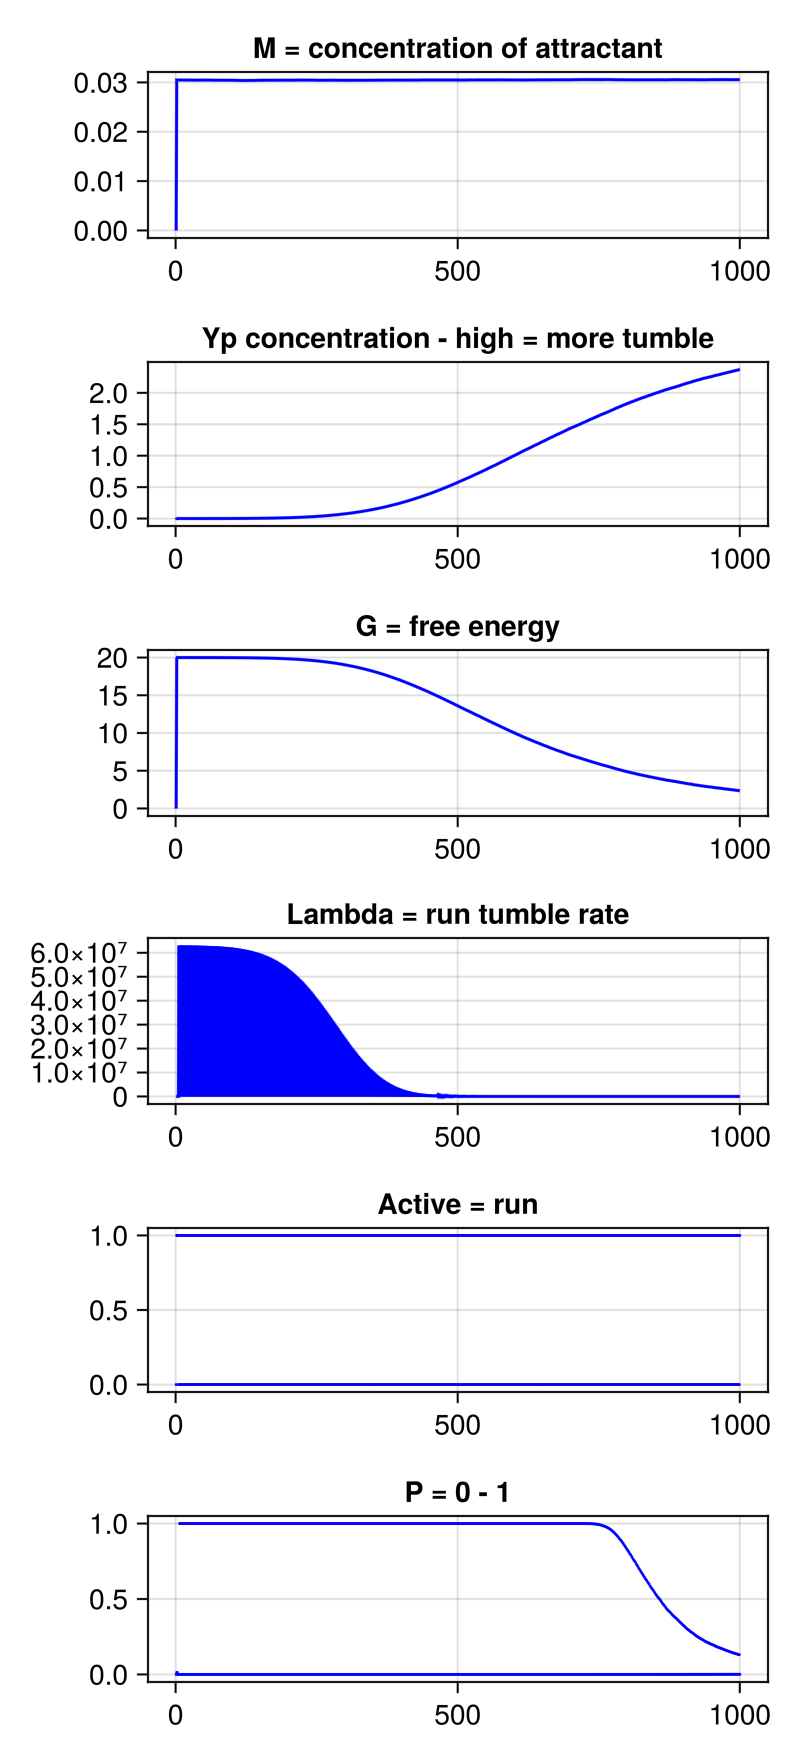

GLMakie.Screen(...)

In [35]:
fig = Figure(size=(400,2500))

ax0 = Axis(fig[1,1], title = "M = concentration of attractant")

lines!(ax0, cell1[!,:step], cell1[!, :M], color = :blue)

ax = Axis(fig[2,1], title = "Yp concentration - high = more tumble")

lines!(ax, cell1[!,:step], cell1[!, :Yp], color = :blue)

ax2 = Axis(fig[3,1], title = "G = free energy")

lines!(ax2, cell1[!, :step], cell1[!, :G], color = :blue)

ax3 = Axis(fig[4,1], title = "Lambda = run tumble rate")

lines!(ax3, cell1[!, :step] ,cell1[!, :λ], color = :blue)

ax4 = Axis(fig[5,1], title = "Active = run")

scatter!(ax4, cell1[!, :step], cell1[!,:active], color = :blue, markersize = 2)

ax5 = Axis(fig[6,1], title = "P = 0 - 1")

scatter!(ax5, cell1[!, :step],cell1[!, :P], color = :blue, markersize = 2)

display(fig)


In [45]:
save("test3.png", fig)

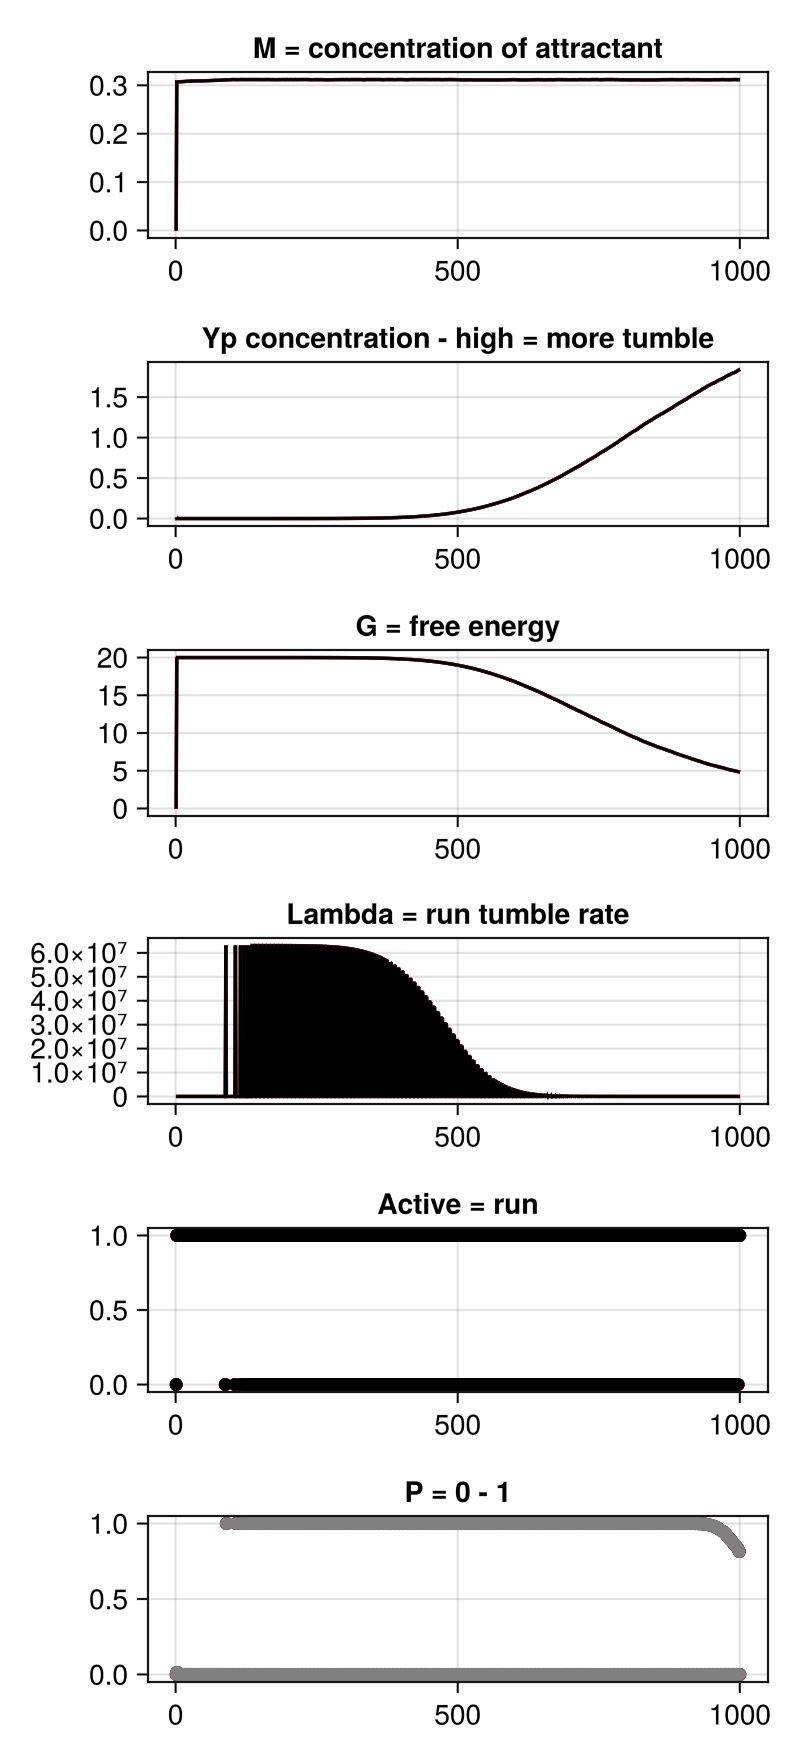

GLMakie.Screen(...)

In [44]:
fig = Figure(size=(400,2500))

ax0 = Axis(fig[1,1], title = "M = concentration of attractant")

lines!(ax0, cell1[!,:step], cell1[!, :M], color = :blue)
lines!(ax0, cell2[!,:step], cell2[!, :M], color = :red)
lines!(ax0, cell3[!,:step], cell3[!, :M], color = :yellow)
lines!(ax0, cell4[!,:step], cell4[!, :M], color = :green)
lines!(ax0, cell5[!,:step], cell5[!, :M], color = :purple)
lines!(ax0, cell6[!,:step], cell6[!, :M], color = :brown)
lines!(ax0, cell7[!,:step], cell7[!, :M], color = :black)

ax = Axis(fig[2,1], title = "Yp concentration - high = more tumble")

lines!(ax, cell1[!,:step], cell1[!, :Yp], color = :blue)
lines!(ax, cell2[!,:step], cell2[!, :Yp], color = :red)
lines!(ax, cell3[!,:step], cell3[!, :Yp], color = :yellow)
lines!(ax, cell4[!,:step], cell4[!, :Yp], color = :green)
lines!(ax, cell5[!,:step], cell5[!, :Yp], color = :purple)
lines!(ax, cell6[!,:step], cell6[!, :Yp], color = :brown)
lines!(ax, cell7[!,:step], cell7[!, :Yp], color = :black)

ax2 = Axis(fig[3,1], title = "G = free energy")

lines!(ax2, cell1[!, :step], cell1[!, :G], color = :blue)
lines!(ax2, cell2[!,:step], cell2[!, :G], color = :red)
lines!(ax2, cell3[!,:step], cell3[!, :G], color = :yellow)
lines!(ax2, cell4[!,:step], cell4[!, :G], color = :green)
lines!(ax2, cell5[!,:step], cell5[!, :G], color = :purple)
lines!(ax2, cell6[!,:step], cell6[!, :G], color = :brown)
lines!(ax2, cell7[!,:step], cell7[!, :G], color = :black)

ax3 = Axis(fig[4,1], title = "Lambda = run tumble rate")

lines!(ax3, cell1[!, :step] ,cell1[!, :λ], color = :blue)
lines!(ax3, cell2[!,:step], cell2[!, :λ], color = :red)
lines!(ax3, cell3[!,:step], cell3[!, :λ], color = :yellow)
lines!(ax3, cell4[!,:step], cell4[!, :λ], color = :green)
lines!(ax3, cell5[!,:step], cell5[!, :λ], color = :purple)
lines!(ax3, cell6[!,:step], cell6[!, :λ], color = :brown)
lines!(ax3, cell7[!,:step], cell7[!, :λ], color = :black)

ax4 = Axis(fig[5,1], title = "Active = run")

scatter!(ax4, cell1[!, :step], cell1[!,:active], color = :blue)
scatter!(ax4, cell2[!,:step], cell2[!, :active], color = :red)
scatter!(ax4, cell3[!,:step], cell3[!, :active], color = :yellow)
scatter!(ax4, cell4[!,:step], cell4[!, :active], color = :green)
scatter!(ax4, cell5[!,:step], cell5[!, :active], color = :purple)
scatter!(ax4, cell6[!,:step], cell6[!, :active], color = :brown)
scatter!(ax4, cell7[!,:step], cell7[!, :active], color = :black)

ax5 = Axis(fig[6,1], title = "P = 0 - 1")

scatter!(ax5, cell1[!, :step],cell1[!, :P], color = :blue)
scatter!(ax5, cell2[!,:step], cell2[!, :P], color = :red)
scatter!(ax5, cell3[!,:step], cell3[!, :P], color = :yellow)
scatter!(ax5, cell4[!,:step], cell4[!, :P], color = :green)
scatter!(ax5, cell5[!,:step], cell5[!, :P], color = :purple)
scatter!(ax5, cell6[!,:step], cell6[!, :P], color = :brown)
scatter!(ax5, cell7[!,:step], cell7[!, :P], color = :grey)

display(fig)
